### Download the data for the lab

We will be using some discharge and climate reanalysis data for the Siuslaw River, Oregon. The data is available on Dropbox (see Slack or Canvas for link). Download `lab5/siuslaw_training_data.csv` to your local machine. 

Once you have launched the notebook and downloaded the data, we are ready to begin...

### Background

Mapleton, OR is a logging town located on the banks of the Siuslaw River, Lane County. It has been subjected to recurring floods throughout its history because the coastal range mountains receive high rainfall and the Siuslaw River Valley is narrow, with steep mountains that rise up directly from the floodplain.

<img src="images/siuslaw_river.jpeg" alt="Siuslaw River" width="500"/>

In February 1996, a series of intense subtropical storms brought record-breaking rain and warm temperatures to the West Coast. This melted the deep snowpack, causing enhanced river discharges and flooding across much of Oregon. The flooding was comparable in magnitude to the December, 1964 flood, the largest in Oregon since flood control reservoirs were built in the 1940's and 1950's. During this flood, the Siuslaw River flooded many homes in Mapleton. 

<img src="images/mapleton_flood_1996.gif" alt="Mapleton Flood 1996" width="500"/>

The USGS maintains water level gauges on the Siuslaw River near Mapleton. However, these gauges sometimes break and are not replaced immediately. In our case, the Siuslaw River gauges were out-of-action for between 1995 and 2000. Furthermore, the USGS gauges in Siuslaw River were only installed in 1968. It is therefore difficult to quantify how anomalous the 1964 flood event was compared with 1996. In this lab, we will attempt to contextualize the 1964 and 1996 floods in Mapleton using machine learning to 1) fill 1995-200 gap in the Siuslaw River discharge record 2) extend the discharge record back in time.

In [15]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
import matplotlib.pyplot as plt

In [16]:
# Define filepath
filepath = '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab5/'

# Import data
all_data = pd.read_csv(filepath + 'siuslaw_training_data.csv')

# Print first ten columns
all_data.tail(10)

,water_year,t2m,sd,tp,swvl1,swvl2,swvl3,swvl4,discharge
62,2012,282.84485,0.003138,0.004515,0.326648,0.330462,0.327869,0.384807,43900.0
63,2013,283.64725,0.000950,0.004563,0.320214,0.322296,0.329393,0.384919,19200.0
64,2014,283.91766,0.001121,0.003265,0.315200,0.319625,0.336168,0.378497,16000.0
65,2015,285.11758,0.000000,0.003942,0.303523,0.306728,0.317073,0.382742,29800.0
66,2016,284.62247,0.000235,0.004992,0.308880,0.309544,0.311993,0.382439,27800.0
67,2017,283.66656,0.002134,0.006251,0.330969,0.337304,0.347865,0.399569,19200.0
68,2018,283.82913,0.000940,0.003664,0.304758,0.311000,0.324310,0.387777,10800.0
69,2019,283.90158,0.003671,0.004091,0.314294,0.313242,0.312805,0.379120,23900.0
70,2020,284.02698,0.001022,0.003462,0.321272,0.326257,0.329570,0.377656,11700.0
71,2021,283.99457,0.000479,0.003992,0.299663,0.305132,0.308231,0.378143,25000.0


The dataset contains the following predictor variables:
* `t2m` = air temperature at 2 m (K)
* `sd` = snow depth (m)
* `tp` = total precipitation (m)
* `swvlx` = soil moisture at four different depths (1 = 0-7 cm, 2 = 7-28 cm, 3 = 28-100 cm, and 4 = 100-289 cm) (m3 m-3)

These variables were derived from the nearest ERA5 climate reanalysis grid cell to Mapleton, OR. More information can be found [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview). They represent the **average** over the water year (i.e. Oct 1 to Sep 30).

The response variable (i.e. the variable we want to predict) is the **maximum** discharge in each water year.
* `discharge` = discharge (cubic feet per second)

### Exploratory data analysis

Let's plot the raw data to see what we have.

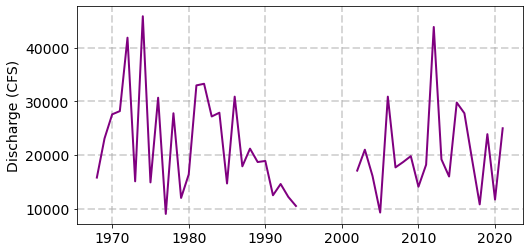

In [43]:
# Plot discharge
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(all_data['water_year'], all_data['discharge'], lw=2, color='purple')
ax.set_ylabel('Discharge (CFS)', fontsize=14)
ax.grid(ls='dashed', lw=2, alpha=0.5, zorder=1)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

As expected there are some missing values in the late 90s. We will train a machine learning model to figure out what these values could have been using the predictor variables (i.e. air temperature, precipitation, snow depth etc.). First we will explore how these predictor variables relate to discharge using scatter plots. 

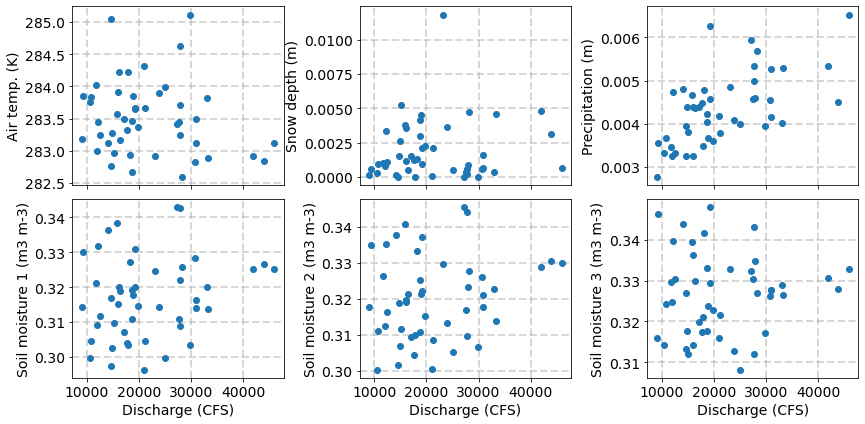

In [37]:
# Plot
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12,6),
                                             sharex=True)

ax1.scatter(all_data['discharge'], all_data['t2m'], zorder=2)
ax2.scatter(all_data['discharge'], all_data['sd'], zorder=2)
ax3.scatter(all_data['discharge'], all_data['tp'], zorder=2)
ax4.scatter(all_data['discharge'], all_data['swvl1'], zorder=2)
ax5.scatter(all_data['discharge'], all_data['swvl2'], zorder=2)
ax6.scatter(all_data['discharge'], all_data['swvl3'], zorder=2)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.grid(ls='dashed', lw=2, alpha=0.5, zorder=1)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

ax4.set_xlabel('Discharge (CFS)', fontsize=14)
ax5.set_xlabel('Discharge (CFS)', fontsize=14)
ax6.set_xlabel('Discharge (CFS)', fontsize=14)

ax1.set_ylabel('Air temp. (K)', fontsize=14)
ax2.set_ylabel('Snow depth (m)', fontsize=14)
ax3.set_ylabel('Precipitation (m)', fontsize=14)
ax4.set_ylabel('Soil moisture 1 (m3 m-3)', fontsize=14)
ax5.set_ylabel('Soil moisture 2 (m3 m-3)', fontsize=14)
ax6.set_ylabel('Soil moisture 3 (m3 m-3)', fontsize=14)

fig.tight_layout()

The scatterplots indicate that **mean annual precipitation** is a good predictor of **maximum annual flood discharge** which makes sense. **Mean annual snow depth** and **soil moisture** demonstrate less of a relationship and **mean annual air temperature** appears completely uncorrelated with maximum annual flood discharge. 

Nevertheless, will we move onwards for the purposes of demonstration.

### Prepare data for machine learning

We will first prepare our data for machine learning. To do this, we remove NaNs and separate our data into features (i.e. predictor variables) and labels (i.e. discharge). We will also standardize our predictor variables by removing the mean and scaling to unit variance. This is not strictly necessary for Random Forests but it is good practice for other machine learning models which might behave badly if the individual features do not more or less look like standard normally distributed data.

In [20]:
# Define feature list
feature_list =  ['t2m', 'sd', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4']

# Remove rows with NaNs
training_data = all_data.dropna().copy()

# Define features and labels 
y = training_data['discharge']
X = training_data[feature_list]

# Standarize data (not strictly necessary for Random Forests but good practice)
scaler = StandardScaler()  
X_scaled = scaler.fit(X).transform(X)

### Train machine learning model

We will now **train** a machine learning model to predict **max. annual discharge** using the predictor variables. We don't want to use all our data to train the model because otherwise we will have no way of evaluating the performance of the model. So we split our data into **two subsets**, one for training and one for testing. `scikit-learn` makes this step very simple. Here we are going to train the model on 80% of the data and keep 20% back for testing. 

In [21]:
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Next we define a classifer. In this case, we will use a Random Forests Regressor with 100 trees. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [22]:
# Define classifier
classifier = RandomForestRegressor(n_estimators=100)

Now we train the model by passing our training set to the `fit` method.

In [23]:
# Train classifier
classifier.fit(X_train, y_train)

RandomForestRegressor()

That's it. Now the model is trained and we can use the `classifier` object to `predict` new values. We will first predict the discharge using predictor variables in our testing dataset.

In [24]:
# Predict
predictions = classifier.predict(X_test)

### Model evaluation

We can compare these predictions to the observed discharge values in our testing dataset using a mean absolute squared error. The units of this metric will be cubic feet per second. 

In [25]:
# Calculate the absolute errors
errors = abs(predictions - predictions)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 3))

Mean Absolute Error: 6038.7


We can also compute a mean absolute percentage error (i.e. between 0 and 100%). 

In [26]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 64.61 %.


OK our model is not that great. But let's use it predict discharge for our entire record and compare it to observed discharge.

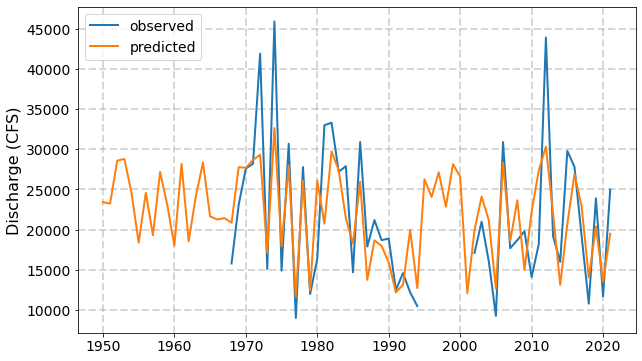

In [44]:
# Define features
X = all_data[feature_list]

# Standarize data again
scaler = StandardScaler()  
X_scaled = scaler.fit(X).transform(X)

# Make predictions
predictions = classifier.predict(X_scaled)

# Add to original DataFrame
all_data['predictions'] = predictions

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(all_data['water_year'], all_data['discharge'], lw=2, label='observed')
ax.plot(all_data['water_year'], all_data['predictions'], lw=2, label='predicted')
ax.grid(ls='dashed', lw=2, alpha=0.5, zorder=1)
ax.set_ylabel('Discharge (CFS)', fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=14)

It's a fairly bad model and probably needs some work before we ring up the USGS. I have some ideas why it doesn't work that well. 

* ERA5 climate reanalysis does not capture full range of conditions that prime this catchment for large stream flows. This is plausible since ERA5 is a global reanalysis and there are likely to biases at the local scale. Some variables (e.g. snow depth and precipitation) are notoriously challenging to model accurately. 


* The annually-averaged feature variables are poor predictors of a single maximum discharge event. Some feature engineering (e.g. winter precipitation or winter snow depth) might improve model predictions of the annual flood magnitude. 


* The Random Forest algorithm is not particularly well suited to this task. Perhaps another model (e.g. neural net) would perform better. 